In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# Necessary Import

In [2]:
!pip install pydotplus
!pip install missingno
!pip install xgboost
!pip install lightgbm
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.7/278.7 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24552 sha256=18a565095e1ec6bbf32be0f87734fb53718a206456e4ea8be910b70bed807918
  Stored in directory: /root/.cache/pip/wheels/69/b2/67/08f0eef649af92df772c09f451558298e07fab1bc7cdf33db0
Successfully built pydotplus


In [3]:
import warnings
import joblib
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

from sklearn.metrics import classification_report, roc_auc_score, mean_squared_error

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, validation_curve
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

In [4]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)

pd.set_option('display.max_columns', None)  # bütün sütunları göster
pd.set_option('display.max_rows', None)     # bütün satırları göster
pd.set_option('display.width', 500)  # sütunlar max 500 tane gösterilsin
pd.set_option('display.expand_frame_repr', False)  # çıktının tek bir satırda olmasını sağlar

# Loading Data Sets / Veri Setini Yükleme

In [5]:
train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

In [6]:
train.shape

(1460, 81)

In [7]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
test.shape

(1459, 80)

In [9]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [10]:
df = pd.concat([train,test], axis=0).reset_index(drop=True)

# Exploratory Data Analysis (EDA) / Keşifçi Veri Analizi

In [11]:
df.shape

(2919, 81)

In [12]:
df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1       float64
BsmtFinType2      object
BsmtFinSF2       float64
BsmtUnfSF        float64
TotalBsmtSF      float64
Heating           object


In [13]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [14]:
df.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,NaN,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,80,32,0,0,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN
2918,2919,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,2Story,7,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,BrkFace,94.0,TA,TA,PConc,Gd,TA,Av,LwQ,758.0,Unf,0.0,238.0,996.0,GasA,Ex,Y,SBrkr,996,1004,0,2000,0.0,0.0,2,1,3,1,TA,9,Typ,1,TA,Attchd,1993.0,Fin,3.0,650.0,TA,TA,Y,190,48,0,0,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal,NaN


In [15]:
df.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            4
LotFrontage       486
LotArea             0
Street              0
Alley            2721
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType       1766
MasVnrArea         23
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           81
BsmtCond           82
BsmtExposure       82
BsmtFinType1       79
BsmtFinSF1          1
BsmtFinType2       80
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

# Grabbing Categoric and Numeric Columns / Kategorik ve Nümerik Kolonları Yakalama

In [16]:
def grab_col_names(dataframe, cat_th=20, car_th=30):
    """
    grab_col_names for given dataframe

    :param dataframe:
    :param cat_th:
    :param car_th:
    :return:
    """

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    # cat_cols + num_cols + cat_but_car = değişken sayısı.
    # num_but_cat cat_cols'un içerisinde zaten.
    # dolayısıyla tüm şu 3 liste ile tüm değişkenler seçilmiş olacaktır: cat_cols + num_cols + cat_but_car
    # num_but_cat sadece raporlama için verilmiştir.

    return cat_cols, cat_but_car, num_cols



cat_cols, cat_but_car, num_cols = grab_col_names(df)

Observations: 2919
Variables: 81
cat_cols: 58
num_cols: 23
cat_but_car: 0
num_but_cat: 15


In [17]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

for col in cat_cols:
    cat_summary(df, col)        

          MSZoning      Ratio
MSZoning                     
RL            2265  77.595067
RM             460  15.758822
FV             139   4.761905
RH              26   0.890716
C (all)         25   0.856458
        Street    Ratio
Street                 
Pave      2907  99.5889
Grvl        12   0.4111
       Alley     Ratio
Alley                 
Grvl     120  4.110997
Pave      78  2.672148
          LotShape      Ratio
LotShape                     
Reg           1859  63.686194
IR1            968  33.162042
IR2             76   2.603631
IR3             16   0.548133
             LandContour      Ratio
LandContour                        
Lvl                 2622  89.825283
HLS                  120   4.110997
Bnk                  117   4.008222
Low                   60   2.055498
           Utilities      Ratio
Utilities                      
AllPub          2916  99.897225
NoSeWa             1   0.034258
           LotConfig      Ratio
LotConfig                      
Inside        

count    2919.000000
mean     1460.000000
std       842.787043
min         1.000000
5%        146.900000
10%       292.800000
20%       584.600000
30%       876.400000
40%      1168.200000
50%      1460.000000
60%      1751.800000
70%      2043.600000
80%      2335.400000
90%      2627.200000
95%      2773.100000
99%      2889.820000
max      2919.000000
Name: Id, dtype: float64


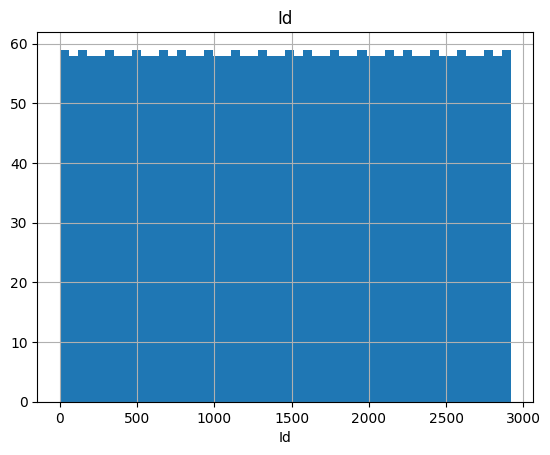

#####################################
count    2433.000000
mean       69.305795
std        23.344905
min        21.000000
5%         32.000000
10%        43.000000
20%        53.000000
30%        60.000000
40%        63.000000
50%        68.000000
60%        73.000000
70%        78.000000
80%        84.000000
90%        95.000000
95%       107.000000
99%       135.680000
max       313.000000
Name: LotFrontage, dtype: float64


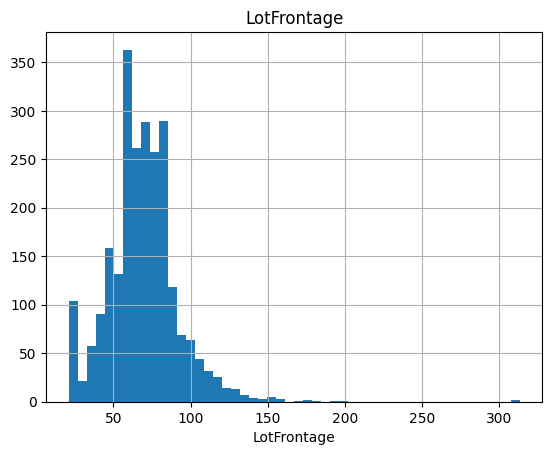

#####################################
count      2919.000000
mean      10168.114080
std        7886.996359
min        1300.000000
5%         3182.000000
10%        4922.400000
20%        7007.600000
30%        7960.400000
40%        8741.000000
50%        9453.000000
60%       10151.600000
70%       11001.200000
80%       12203.800000
90%       14300.600000
95%       17142.900000
99%       33038.640000
max      215245.000000
Name: LotArea, dtype: float64


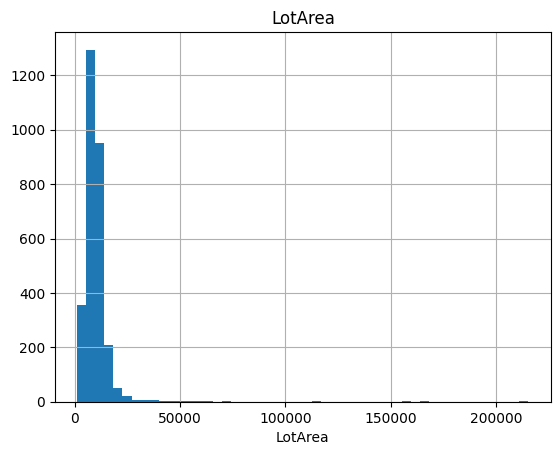

#####################################
count    2919.000000
mean     1971.312778
std        30.291442
min      1872.000000
5%       1915.000000
10%      1924.000000
20%      1947.000000
30%      1957.000000
40%      1965.000000
50%      1973.000000
60%      1984.000000
70%      1998.000000
80%      2003.000000
90%      2006.000000
95%      2007.000000
99%      2008.000000
max      2010.000000
Name: YearBuilt, dtype: float64


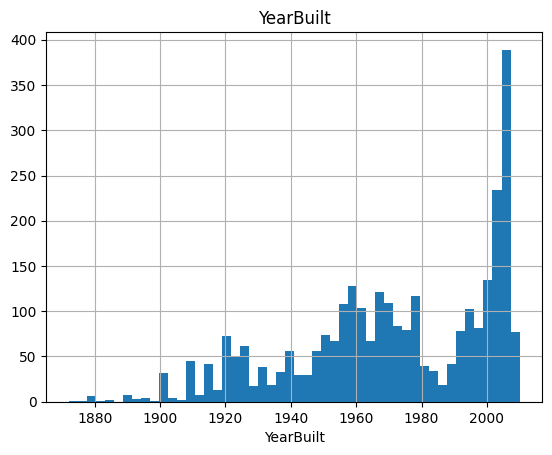

#####################################
count    2919.000000
mean     1984.264474
std        20.894344
min      1950.000000
5%       1950.000000
10%      1950.000000
20%      1960.000000
30%      1970.000000
40%      1978.000000
50%      1993.000000
60%      1998.000000
70%      2002.000000
80%      2005.000000
90%      2006.200000
95%      2007.000000
99%      2009.000000
max      2010.000000
Name: YearRemodAdd, dtype: float64


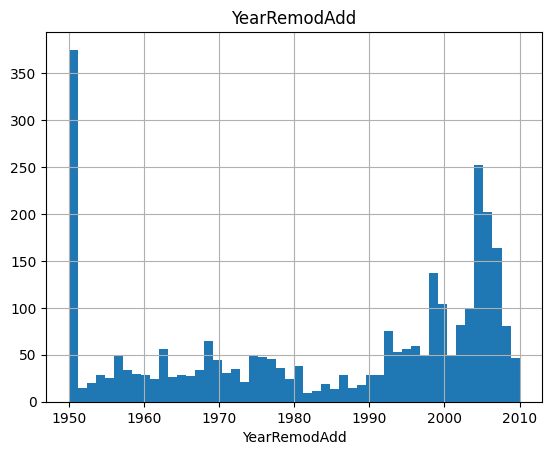

#####################################
count    2896.000000
mean      102.201312
std       179.334253
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%       120.000000
80%       202.000000
90%       325.500000
95%       466.500000
99%       771.050000
max      1600.000000
Name: MasVnrArea, dtype: float64


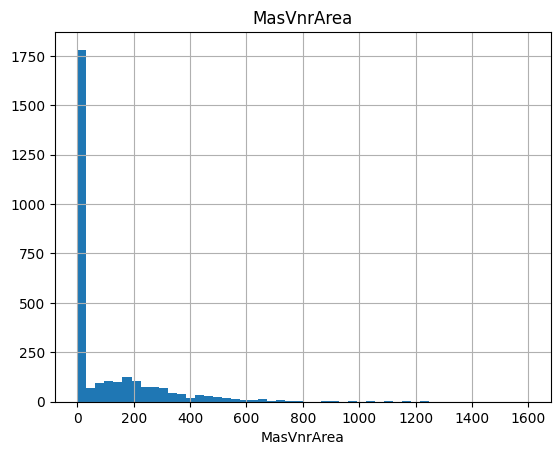

#####################################
count    2918.000000
mean      441.423235
std       455.610826
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%       202.600000
50%       368.500000
60%       515.200000
70%       656.000000
80%       812.000000
90%      1056.900000
95%      1274.000000
99%      1635.320000
max      5644.000000
Name: BsmtFinSF1, dtype: float64


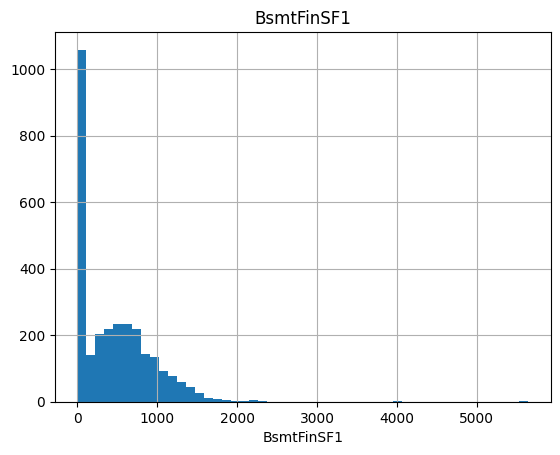

#####################################
count    2918.000000
mean       49.582248
std       169.205611
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.000000
80%         0.000000
90%       125.600000
95%       435.000000
99%       874.660000
max      1526.000000
Name: BsmtFinSF2, dtype: float64


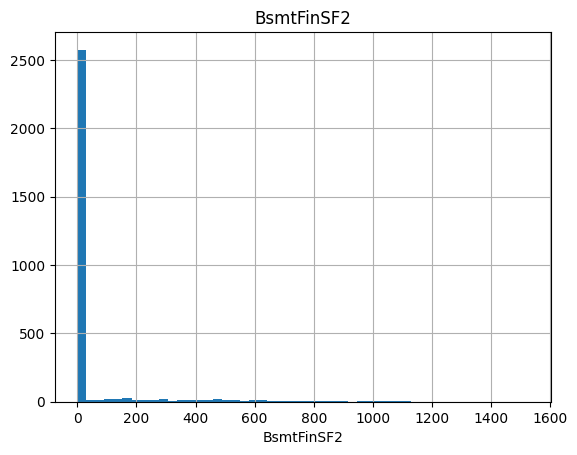

#####################################
count    2918.000000
mean      560.772104
std       439.543659
min         0.000000
5%          0.000000
10%        56.000000
20%       174.000000
30%       270.000000
40%       365.800000
50%       467.000000
60%       595.000000
70%       732.000000
80%       892.600000
90%      1212.600000
95%      1474.900000
99%      1776.490000
max      2336.000000
Name: BsmtUnfSF, dtype: float64


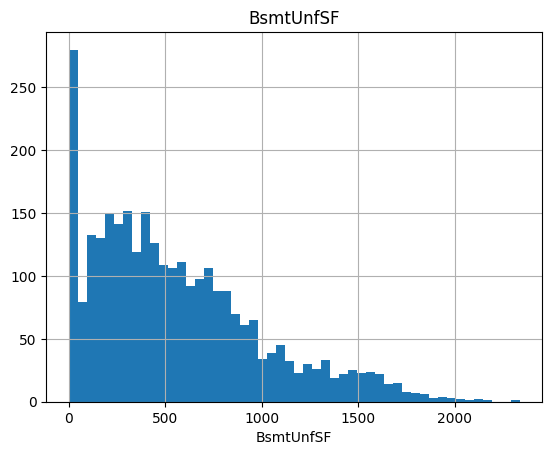

#####################################
count    2918.000000
mean     1051.777587
std       440.766258
min         0.000000
5%        455.250000
10%       600.000000
20%       741.000000
30%       836.000000
40%       911.000000
50%       989.500000
60%      1089.200000
70%      1216.000000
80%      1392.000000
90%      1614.000000
95%      1776.150000
99%      2198.300000
max      6110.000000
Name: TotalBsmtSF, dtype: float64


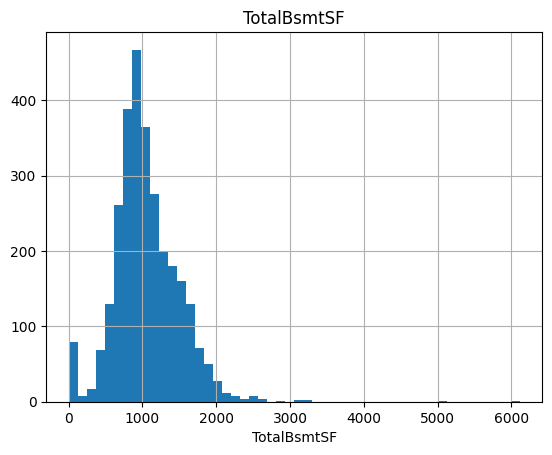

#####################################
count    2919.000000
mean     1159.581706
std       392.362079
min       334.000000
5%        665.900000
10%       744.800000
20%       847.000000
30%       914.000000
40%       996.200000
50%      1082.000000
60%      1180.000000
70%      1314.000000
80%      1483.400000
90%      1675.000000
95%      1830.100000
99%      2288.020000
max      5095.000000
Name: 1stFlrSF, dtype: float64


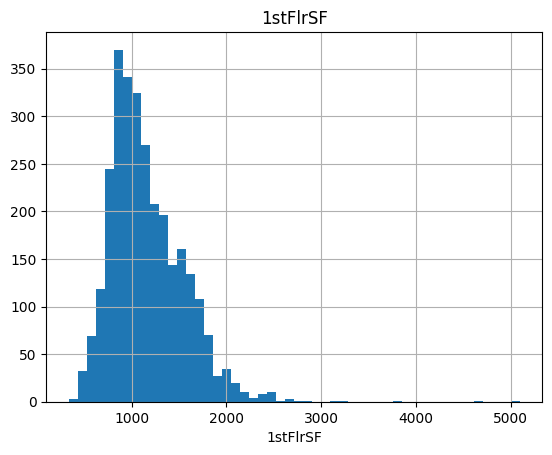

#####################################
count    2919.000000
mean      336.483727
std       428.701456
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%       427.400000
70%       636.000000
80%       770.800000
90%       925.000000
95%      1131.200000
99%      1400.200000
max      2065.000000
Name: 2ndFlrSF, dtype: float64


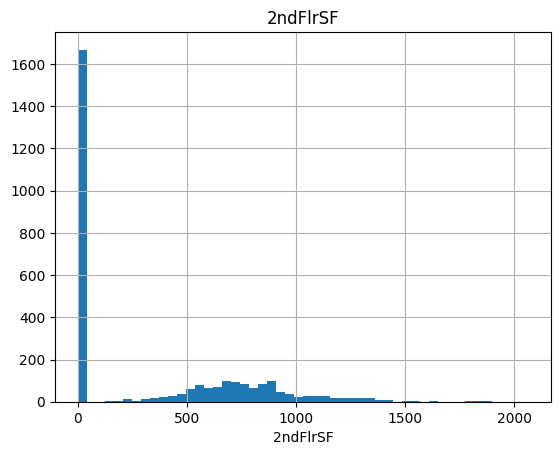

#####################################
count    2919.000000
mean        4.694416
std        46.396825
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.000000
80%         0.000000
90%         0.000000
95%         0.000000
99%       153.840000
max      1064.000000
Name: LowQualFinSF, dtype: float64


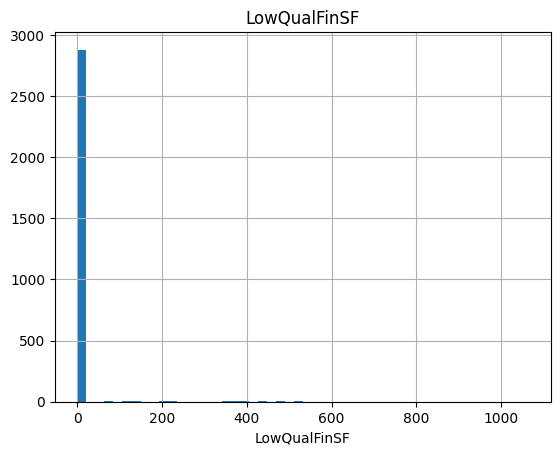

#####################################
count    2919.000000
mean     1500.759849
std       506.051045
min       334.000000
5%        861.000000
10%       923.800000
20%      1064.600000
30%      1200.000000
40%      1329.200000
50%      1444.000000
60%      1560.000000
70%      1680.000000
80%      1838.400000
90%      2153.200000
95%      2464.200000
99%      2935.720000
max      5642.000000
Name: GrLivArea, dtype: float64


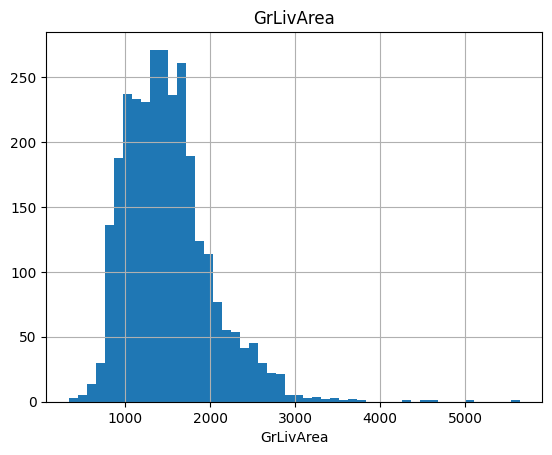

#####################################
count    2760.000000
mean     1978.113406
std        25.574285
min      1895.000000
5%       1928.000000
10%      1941.000000
20%      1957.000000
30%      1964.000000
40%      1972.000000
50%      1979.000000
60%      1993.000000
70%      1999.000000
80%      2004.000000
90%      2006.000000
95%      2007.000000
99%      2009.000000
max      2207.000000
Name: GarageYrBlt, dtype: float64


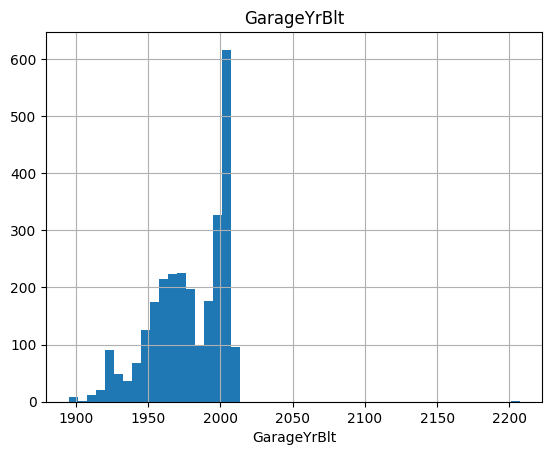

#####################################
count    2918.000000
mean      472.874572
std       215.394815
min         0.000000
5%          0.000000
10%       240.000000
20%       296.000000
30%       379.000000
40%       440.000000
50%       480.000000
60%       513.000000
70%       560.900000
80%       621.000000
90%       758.000000
95%       856.150000
99%      1019.490000
max      1488.000000
Name: GarageArea, dtype: float64


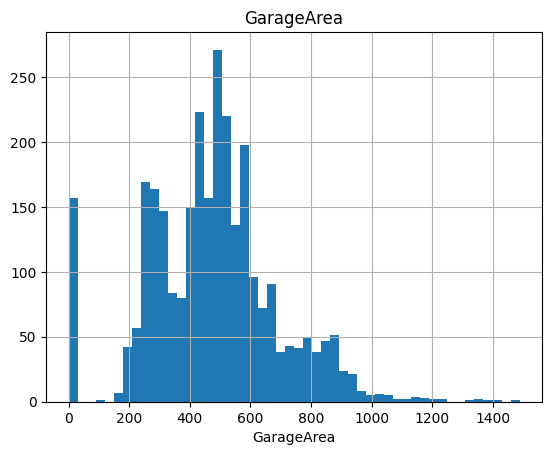

#####################################
count    2919.000000
mean       93.709832
std       126.526589
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%       100.000000
70%       144.000000
80%       192.000000
90%       257.000000
95%       328.000000
99%       500.820000
max      1424.000000
Name: WoodDeckSF, dtype: float64


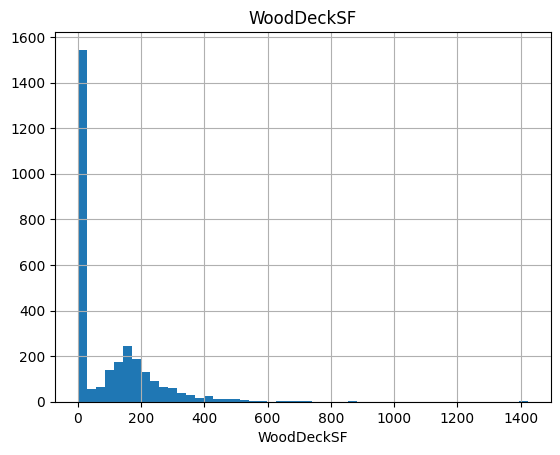

#####################################
count    2919.000000
mean       47.486811
std        67.575493
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%        26.000000
60%        40.000000
70%        58.000000
80%        85.000000
90%       131.200000
95%       183.100000
99%       284.460000
max       742.000000
Name: OpenPorchSF, dtype: float64


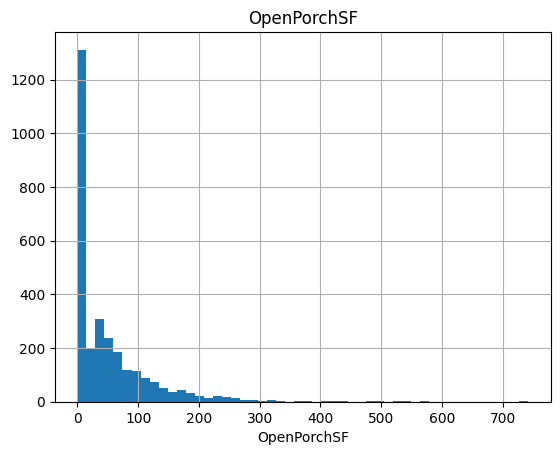

#####################################
count    2919.000000
mean       23.098321
std        64.244246
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.000000
80%         0.000000
90%       112.000000
95%       176.000000
99%       264.000000
max      1012.000000
Name: EnclosedPorch, dtype: float64


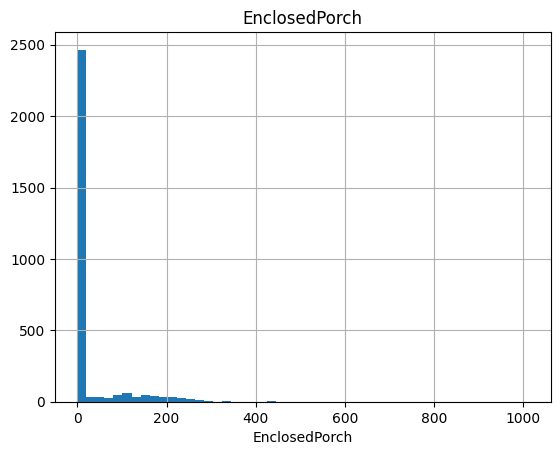

#####################################
count    2919.000000
mean        2.602261
std        25.188169
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.000000
80%         0.000000
90%         0.000000
95%         0.000000
99%       144.000000
max       508.000000
Name: 3SsnPorch, dtype: float64


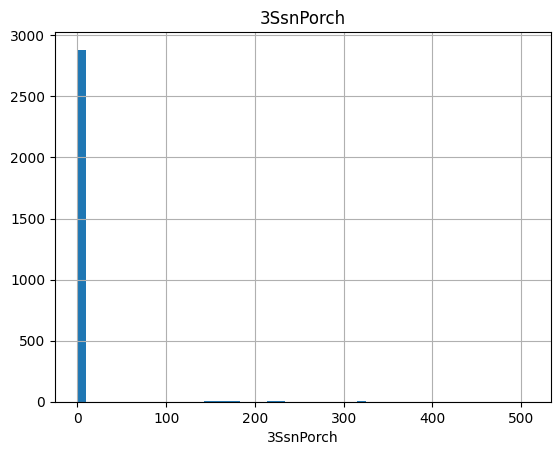

#####################################
count    2919.000000
mean       16.062350
std        56.184365
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.000000
80%         0.000000
90%         0.000000
95%       161.000000
99%       259.820000
max       576.000000
Name: ScreenPorch, dtype: float64


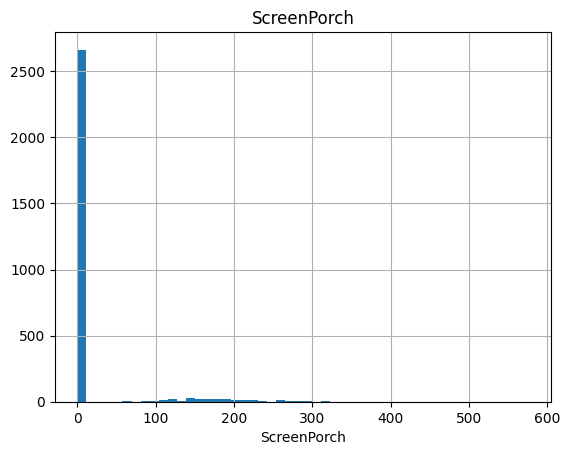

#####################################
count     2919.000000
mean        50.825968
std        567.402211
min          0.000000
5%           0.000000
10%          0.000000
20%          0.000000
30%          0.000000
40%          0.000000
50%          0.000000
60%          0.000000
70%          0.000000
80%          0.000000
90%          0.000000
95%          0.000000
99%        982.000000
max      17000.000000
Name: MiscVal, dtype: float64


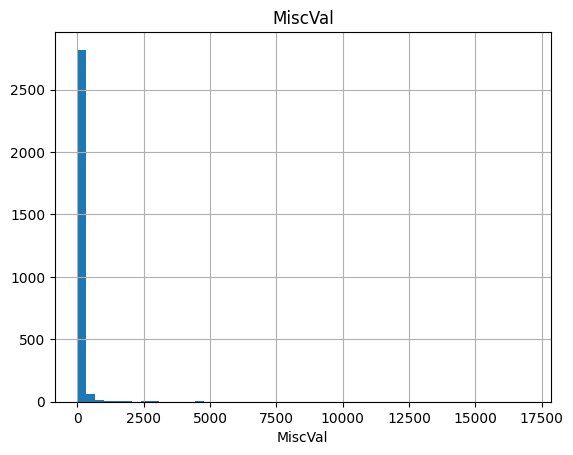

#####################################
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
5%        88000.000000
10%      106475.000000
20%      124000.000000
30%      135500.000000
40%      147000.000000
50%      163000.000000
60%      179280.000000
70%      198620.000000
80%      230000.000000
90%      278000.000000
95%      326100.000000
99%      442567.010000
max      755000.000000
Name: SalePrice, dtype: float64


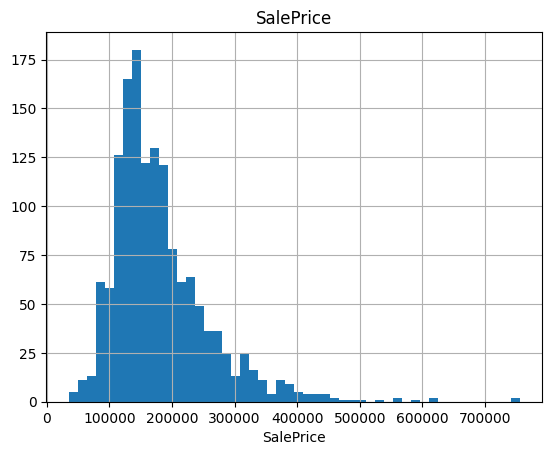

#####################################


In [18]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

    print("#####################################")
    
    
for col in num_cols:
    num_summary(df, col, True) 

In [19]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

for col in cat_cols:
    target_summary_with_cat(df,"SalePrice",col)

            TARGET_MEAN
MSZoning               
C (all)    74528.000000
FV        214014.061538
RH        131558.375000
RL        191004.994787
RM        126316.830275


          TARGET_MEAN
Street               
Grvl    130190.500000
Pave    181130.538514


         TARGET_MEAN
Alley               
Grvl   122219.080000
Pave   168000.585366


            TARGET_MEAN
LotShape               
IR1       206101.665289
IR2       239833.365854
IR3       216036.500000
Reg       164754.818378


               TARGET_MEAN
LandContour               
Bnk          143104.079365
HLS          231533.940000
Low          203661.111111
Lvl          180183.746758


            TARGET_MEAN
Utilities              
AllPub     180950.95682
NoSeWa     137500.00000


             TARGET_MEAN
LotConfig               
Corner     181623.425856
CulDSac    223854.617021
FR2        177934.574468
FR3        208475.000000
Inside     176938.047529


             TARGET_MEAN
LandSlope               
Gtl        179956.7

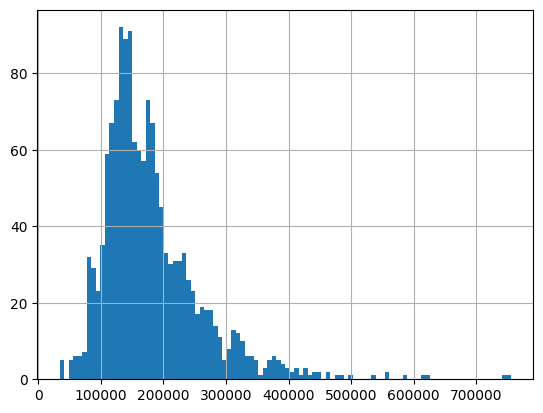

In [20]:
df["SalePrice"].hist(bins=100)
plt.show()

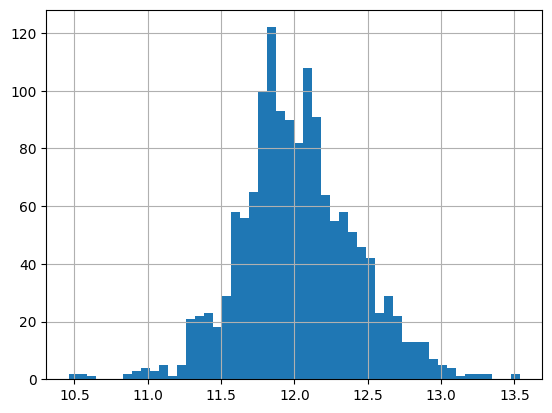

In [21]:
# Applying Log Transformation / Log Dönüşümü Uygulama 
np.log1p(df['SalePrice']).hist(bins=50)
plt.show()

In [22]:
# Correlation Analysis / Korelasyon Analizi
corr = df[num_cols].corr()
corr

,Id,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,SalePrice
Id,1.000000,-0.027549,-0.040746,-0.016581,-0.050438,-0.025219,-0.016947,0.018251,-0.014453,-0.024924,-0.008678,-0.022252,-0.037816,-0.029046,-0.026666,-0.008865,-0.007056,0.009960,0.021609,-0.046538,0.022208,0.008244,-0.021917
LotFrontage,-0.027549,1.000000,0.489896,0.122811,0.091557,0.221079,0.219408,0.047431,0.113714,0.354822,0.458247,0.026545,0.004894,0.382462,0.076673,0.359786,0.122070,0.164896,0.011509,0.028289,0.075858,0.044272,0.351799
LotArea,-0.040746,0.489896,1.000000,0.024128,0.021612,0.125596,0.194031,0.084059,0.021362,0.254138,0.332460,0.031515,0.000554,0.284519,-0.008628,0.213251,0.158045,0.104797,0.020974,0.015995,0.054375,0.069029,0.263843
YearBuilt,-0.016581,0.122811,0.024128,1.000000,0.612235,0.314051,0.279581,-0.027595,0.130473,0.408515,0.310814,0.017588,-0.144191,0.242666,0.834812,0.480735,0.229426,0.198554,-0.374073,0.015958,-0.041046,-0.010886,0.522897
YearRemodAdd,-0.050438,0.091557,0.021612,0.612235,1.000000,0.196875,0.152126,-0.062153,0.165175,0.298107,0.242245,0.158985,-0.060371,0.316972,0.652365,0.376765,0.218513,0.242182,-0.220456,0.037433,-0.046878,-0.003124,0.507101
MasVnrArea,-0.025219,0.221079,0.125596,0.314051,0.196875,1.000000,0.303490,-0.015645,0.090163,0.397240,0.395834,0.121014,-0.057912,0.402994,0.255112,0.374061,0.166200,0.144650,-0.111499,0.013612,0.065209,0.044811,0.477493
BsmtFinSF1,-0.016947,0.219408,0.194031,0.279581,0.152126,0.303490,1.000000,-0.055045,-0.477404,0.536467,0.458092,-0.162301,-0.066028,0.211669,0.194270,0.310449,0.223492,0.124163,-0.099712,0.050908,0.096823,0.093295,0.386420
BsmtFinSF2,0.018251,0.047431,0.084059,-0.027595,-0.062153,-0.015645,-0.055045,1.000000,-0.238241,0.089410,0.084330,-0.097744,-0.004923,-0.017872,-0.068549,0.003139,0.098399,-0.005876,0.032740,-0.023279,0.063302,-0.005139,-0.011378
BsmtUnfSF,-0.014453,0.113714,0.021362,0.130473,0.165175,0.090163,-0.477404,-0.238241,1.000000,0.412285,0.296600,-0.000376,0.046913,0.233988,0.171588,0.164409,-0.039302,0.119764,0.005006,-0.005810,-0.049158,-0.010492,0.214479
TotalBsmtSF,-0.024924,0.354822,0.254138,0.408515,0.298107,0.397240,0.536467,0.089410,0.412285,1.000000,0.801670,-0.205665,-0.023359,0.445276,0.348408,0.486067,0.229600,0.245521,-0.085510,0.037892,0.075363,0.084002,0.613581


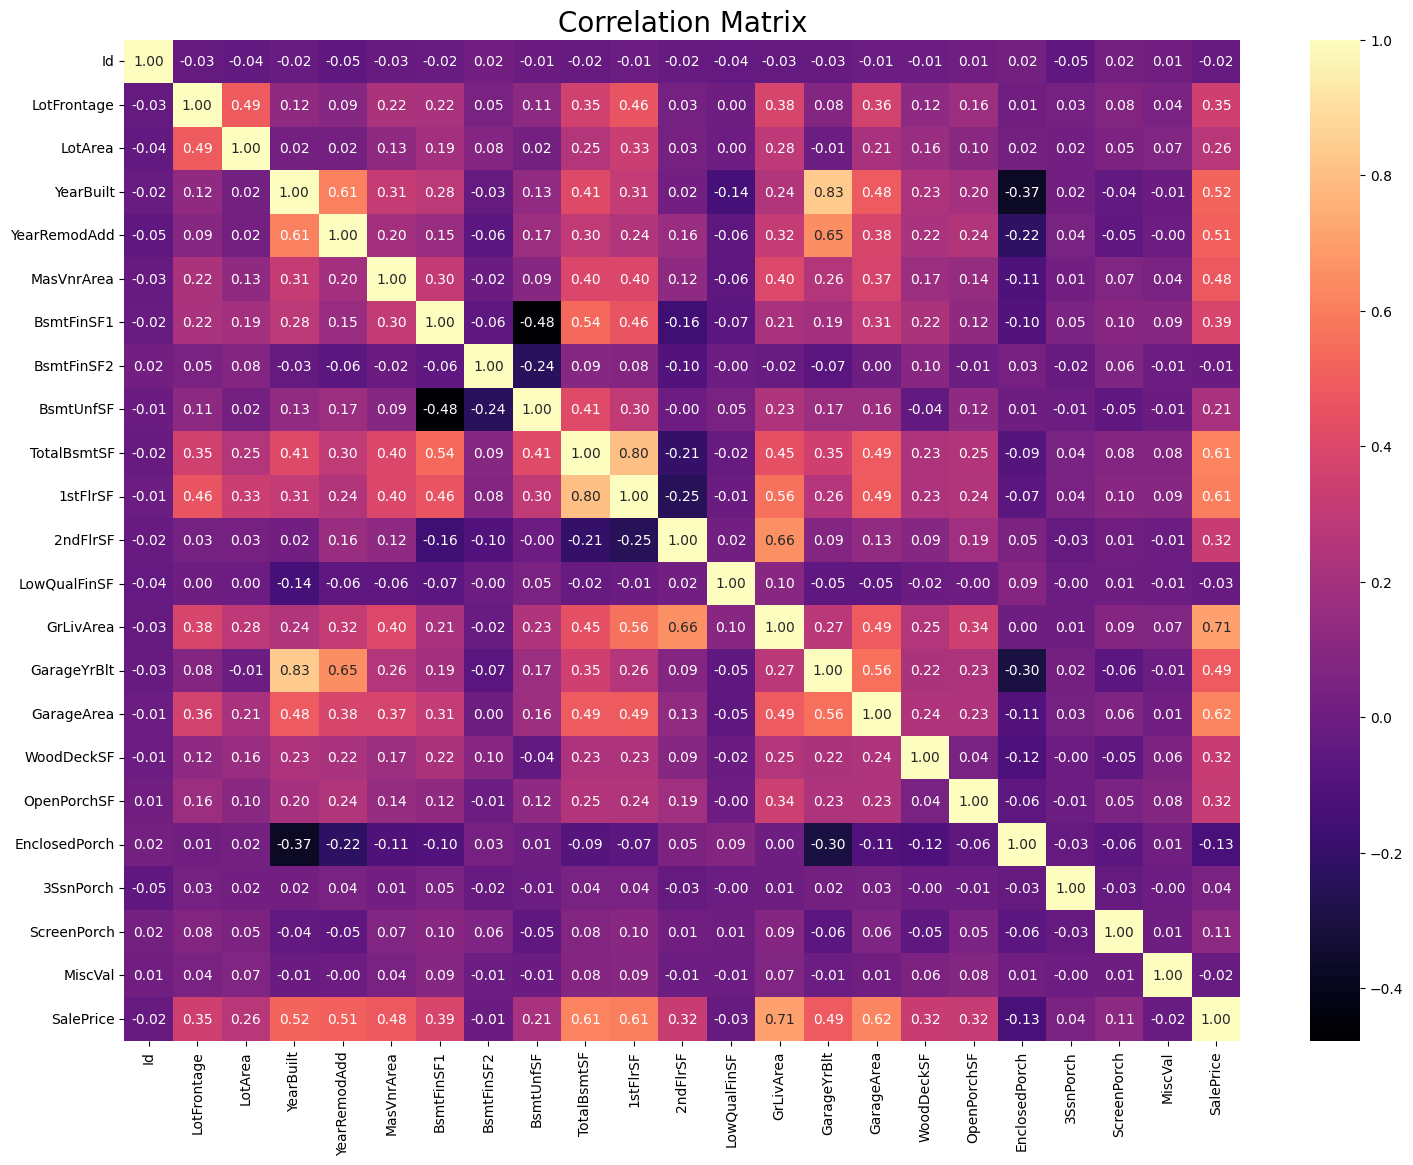

In [23]:
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

In [24]:
# Grabbing Outliar Values / Aykırı Değerleri Yakalama 

def outlier_thresholds(dataframe, variable, low_quantile=0.01, up_quantile=0.99):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
    

    
for col in num_cols:
    if col != "SalePrice":
      print(col, check_outlier(df, col))    

Id False
LotFrontage True
LotArea True
YearBuilt False
YearRemodAdd False
MasVnrArea False
BsmtFinSF1 True
BsmtFinSF2 False
BsmtUnfSF False
TotalBsmtSF True
1stFlrSF True
2ndFlrSF False
LowQualFinSF True
GrLivArea False
GarageYrBlt True
GarageArea False
WoodDeckSF True
OpenPorchSF True
EnclosedPorch True
3SsnPorch True
ScreenPorch False
MiscVal True


In [25]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


for col in num_cols:
    if col != "SalePrice":
        replace_with_thresholds(df,col)

for col in num_cols:
    print(col, check_outlier(df, col))

Id False
LotFrontage False
LotArea False
YearBuilt False
YearRemodAdd False
MasVnrArea False
BsmtFinSF1 False
BsmtFinSF2 False
BsmtUnfSF False
TotalBsmtSF False
1stFlrSF False
2ndFlrSF False
LowQualFinSF False
GrLivArea False
GarageYrBlt False
GarageArea False
WoodDeckSF False
OpenPorchSF False
EnclosedPorch False
3SsnPorch False
ScreenPorch False
MiscVal False
SalePrice False


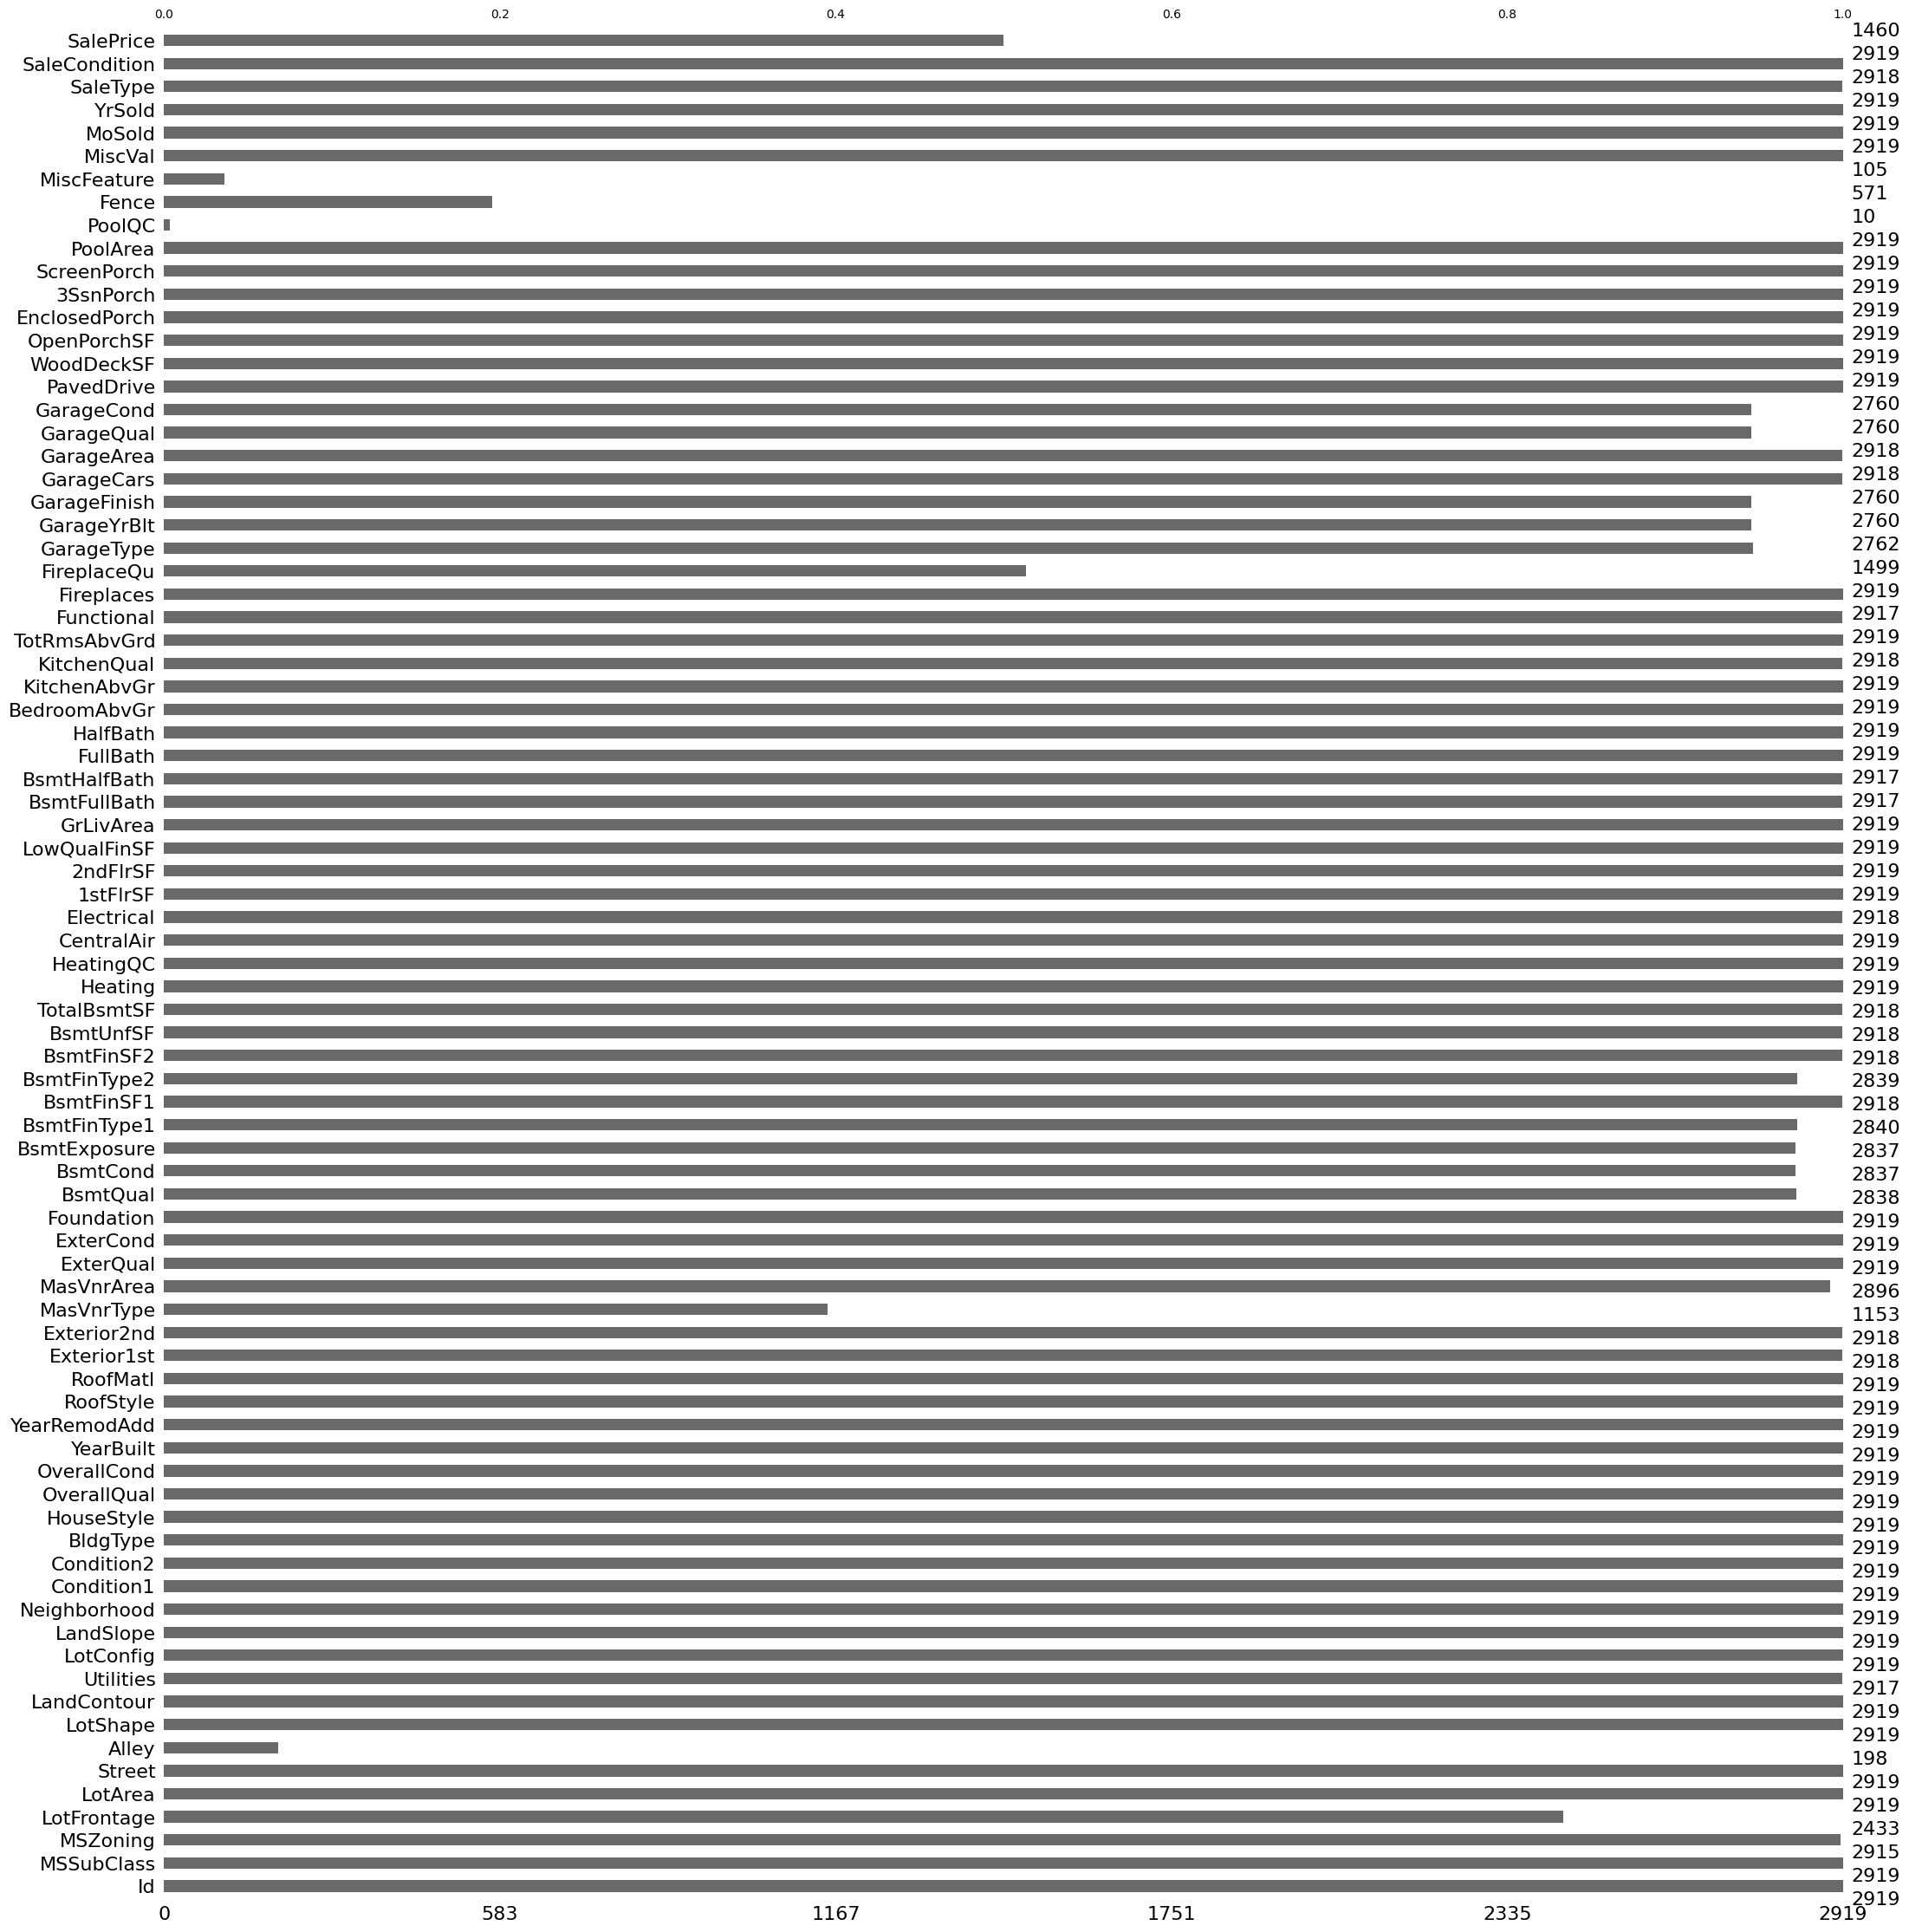

In [26]:
# Missing Values / Eksik Değerler

msno.bar(df)
plt.show()

In [27]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)

    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)

    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])

    print(missing_df, end="\n")

    if na_name:
        return na_columns


missing_values_table(df)

              n_miss  ratio
PoolQC          2909  99.66
MiscFeature     2814  96.40
Alley           2721  93.22
Fence           2348  80.44
MasVnrType      1766  60.50
SalePrice       1459  49.98
FireplaceQu     1420  48.65
LotFrontage      486  16.65
GarageCond       159   5.45
GarageYrBlt      159   5.45
GarageFinish     159   5.45
GarageQual       159   5.45
GarageType       157   5.38
BsmtExposure      82   2.81
BsmtCond          82   2.81
BsmtQual          81   2.77
BsmtFinType2      80   2.74
BsmtFinType1      79   2.71
MasVnrArea        23   0.79
MSZoning           4   0.14
Functional         2   0.07
BsmtHalfBath       2   0.07
BsmtFullBath       2   0.07
Utilities          2   0.07
KitchenQual        1   0.03
TotalBsmtSF        1   0.03
BsmtUnfSF          1   0.03
GarageCars         1   0.03
GarageArea         1   0.03
BsmtFinSF2         1   0.03
BsmtFinSF1         1   0.03
Exterior2nd        1   0.03
Exterior1st        1   0.03
SaleType           1   0.03
Electrical         1

In [28]:
df["Alley"].value_counts()

Alley
Grvl    120
Pave     78
Name: count, dtype: int64

In [29]:
no_cols = ["Alley","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","FireplaceQu",
           "GarageType","GarageFinish","GarageQual","GarageCond","PoolQC","Fence","MiscFeature"]
for col in no_cols:
    df[col].fillna("No",inplace=True)

missing_values_table(df)

              n_miss  ratio
MasVnrType      1766  60.50
SalePrice       1459  49.98
LotFrontage      486  16.65
GarageYrBlt      159   5.45
MasVnrArea        23   0.79
MSZoning           4   0.14
BsmtFullBath       2   0.07
BsmtHalfBath       2   0.07
Functional         2   0.07
Utilities          2   0.07
Exterior2nd        1   0.03
BsmtFinSF1         1   0.03
BsmtFinSF2         1   0.03
BsmtUnfSF          1   0.03
Exterior1st        1   0.03
Electrical         1   0.03
KitchenQual        1   0.03
GarageCars         1   0.03
GarageArea         1   0.03
SaleType           1   0.03
TotalBsmtSF        1   0.03


In [30]:
# Filling Missing Values / Eksik Değerleri Doldurma

def quick_missing_imp(data, num_method="median", cat_length=20, target="SalePrice"):
    variables_with_na = [col for col in data.columns if data[col].isnull().sum() > 0]  # Eksik değere sahip olan değişkenler listelenir

    temp_target = data[target]

    print("# BEFORE")
    print(data[variables_with_na].isnull().sum(), "\n\n")  # Uygulama öncesi değişkenlerin eksik değerlerinin sayısı

    # değişken object ve sınıf sayısı cat_lengthe eşit veya altındaysa boş değerleri mode ile doldur
    data = data.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= cat_length) else x, axis=0)

    # num_method mean ise tipi object olmayan değişkenlerin boş değerleri ortalama ile dolduruluyor
    if num_method == "mean":
        data = data.apply(lambda x: x.fillna(x.mean()) if x.dtype != "O" else x, axis=0)
    # num_method median ise tipi object olmayan değişkenlerin boş değerleri ortalama ile dolduruluyor
    elif num_method == "median":
        data = data.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0)

    data[target] = temp_target

    print("# AFTER \n Imputation method is 'MODE' for categorical variables!")
    print(" Imputation method is '" + num_method.upper() + "' for numeric variables! \n")
    print(data[variables_with_na].isnull().sum(), "\n\n")

    return data


df = quick_missing_imp(df, num_method="median", cat_length=17)


missing_values_table(df)

# BEFORE
MSZoning           4
LotFrontage      486
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType      1766
MasVnrArea        23
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
GarageYrBlt      159
GarageCars         1
GarageArea         1
SaleType           1
SalePrice       1459
dtype: int64 


# AFTER 
 Imputation method is 'MODE' for categorical variables!
 Imputation method is 'MEDIAN' for numeric variables! 

MSZoning           0
LotFrontage        0
Utilities          0
Exterior1st        0
Exterior2nd        0
MasVnrType         0
MasVnrArea         0
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
Electrical         0
BsmtFullBath       0
BsmtHalfBath       0
KitchenQual        0
Functional         0
GarageYrBlt        0
GarageCars         0
GarageArea         0
SaleType      

In [31]:
[col for col in df.columns if df[col].isnull().sum() > 0]

['SalePrice']

# Feature Engineering

In [32]:
# NEW_1st*GrLiv
df["NEW_1st*GrLiv"] = df["1stFlrSF"] * df["GrLivArea"]

# NEW_Garage*GrLiv
df["NEW_Garage*GrLiv"] = df["GarageArea"] * df["GrLivArea"]

# NEW_TotalQual
qual_cols = ["OverallQual", "OverallCond", "ExterQual", "ExterCond", "BsmtCond", "BsmtFinType1",
             "BsmtFinType2", "HeatingQC", "KitchenQual", "Functional", "FireplaceQu", "GarageQual", "GarageCond", "Fence"]
df[qual_cols] = df[qual_cols].apply(pd.to_numeric, errors='coerce')
df["NEW_TotalQual"] = df[qual_cols].sum(axis=1)

# NEW_TotalGarageQual
garage_qual_cols = ["GarageQual", "GarageCond"]
df[garage_qual_cols] = df[garage_qual_cols].apply(pd.to_numeric, errors='coerce')
df["NEW_TotalGarageQual"] = df[garage_qual_cols].sum(axis=1)

# NEW_TotalFlrSF (Total Floor)
df["NEW_TotalFlrSF"] = df["1stFlrSF"] + df["2ndFlrSF"]

# NEW_TotalBsmtFin (Total Finished Basement Area)
df["NEW_TotalBsmtFin"] = df["BsmtFinSF1"] + df["BsmtFinSF2"]

# NEW_PorchArea
df["NEW_PorchArea"] = df["OpenPorchSF"] + df["EnclosedPorch"] + df["ScreenPorch"] + df["3SsnPorch"] + df["WoodDeckSF"]

# NEW_TotalHouseArea
df["NEW_TotalHouseArea"] = df["NEW_TotalFlrSF"] + df["TotalBsmtSF"]

# NEW_TotalSqFeet
df["NEW_TotalSqFeet"] = df["GrLivArea"] + df["TotalBsmtSF"]

# NEW_TotalLot
df["NEW_TotalLot"] = df["LotFrontage"] + df["LotArea"]

# NEW_LotRatio
df["NEW_LotRatio"] = df["GrLivArea"] / df["LotArea"]

# NEW_RatioArea
df["NEW_RatioArea"] = df["NEW_TotalHouseArea"] / df["LotArea"]

# NEW_GarageLotRatio
df["NEW_GarageLotRatio"] = df["GarageArea"] / df["LotArea"]

# NEW_MasVnrRatio
df["NEW_MasVnrRatio"] = df["MasVnrArea"] / df["NEW_TotalHouseArea"]

# NEW_DifArea
df["NEW_DifArea"] = df["LotArea"] - df["1stFlrSF"] - df["GarageArea"] - df["NEW_PorchArea"] - df["WoodDeckSF"]

# NEW_KitchenScore
df["NEW_KitchenScore"] = df["KitchenAbvGr"] * df["KitchenQual"]

# NEW_FireplaceScore
df["NEW_FireplaceScore"] = df["Fireplaces"] * df["FireplaceQu"]

# NEW_OverallGrade
df["NEW_OverallGrade"] = df["OverallQual"] * df["OverallCond"]

# NEW_Overall
df["NEW_Overall"] = df[["OverallQual", "OverallCond"]].sum(axis=1)

# NEW_Bathrooms
df["NEW_Bathrooms"] = df["FullBath"] + df["HalfBath"] * 0.5

# NEW_YearAverage
df["NEW_YearAverage"] = (df["YearRemodAdd"] + df["YearBuilt"]) / 2

# NEW_Restoration
df["NEW_Restoration"] = df["YearRemodAdd"] - df["YearBuilt"]

# NEW_HouseAge
df["NEW_HouseAge"] = df["YrSold"] - df["YearBuilt"]

# NEW_RestorationAge
df["NEW_RestorationAge"] = df["YrSold"] - df["YearRemodAdd"]

# NEW_GarageAge
df["NEW_GarageAge"] = df["GarageYrBlt"] - df["YearBuilt"]

# NEW_GarageRestorationAge
df["NEW_GarageRestorationAge"] = np.abs(df["GarageYrBlt"] - df["YearRemodAdd"])

# NEW_GarageSold
df["NEW_GarageSold"] = df["YrSold"] - df["GarageYrBlt"]


In [33]:
drop_list = ["Street", "Alley", "LandContour", "Utilities", "LandSlope","Heating", "PoolQC", "MiscFeature","Neighborhood"]

In [34]:
cat_cols, cat_but_car, num_cols = grab_col_names(df)

Observations: 2919
Variables: 108
cat_cols: 65
num_cols: 43
cat_but_car: 0
num_but_cat: 34


In [35]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtypes == "O" and len(df[col].unique()) == 2]

for col in binary_cols:
    label_encoder(df, col)

In [36]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,NEW_1st*GrLiv,NEW_Garage*GrLiv,NEW_TotalQual,NEW_TotalGarageQual,NEW_TotalFlrSF,NEW_TotalBsmtFin,NEW_PorchArea,NEW_TotalHouseArea,NEW_TotalSqFeet,NEW_TotalLot,NEW_LotRatio,NEW_RatioArea,NEW_GarageLotRatio,NEW_MasVnrRatio,NEW_DifArea,NEW_KitchenScore,NEW_FireplaceScore,NEW_OverallGrade,NEW_Overall,NEW_Bathrooms,NEW_YearAverage,NEW_Restoration,NEW_HouseAge,NEW_RestorationAge,NEW_GarageAge,NEW_GarageRestorationAge,NEW_GarageSold
0,1.0,60,RL,65.0,8450.0,1,No,Reg,Lvl,0,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,NaN,NaN,PConc,Gd,NaN,No,NaN,706.0,NaN,0.0,150.0,856.0,GasA,NaN,1,SBrkr,856.0,854.0,0.0,1710.0,1.0,0.0,2,1,3,1,NaN,8,NaN,0,NaN,Attchd,2003.0,RFn,2.0,548.0,NaN,NaN,Y,0.0,61.0,0,0,0.0,0,No,NaN,No,0.0,2,2008,WD,Normal,208500.0,1463760.0,937080.0,12.0,0.0,1710.0,706.0,61.0,2566.0,2566.0,8515.0,0.202367,0.303669,0.064852,0.076383,6985.0,NaN,NaN,35,12,2.5,2003.0,0.0,5,5.0,0.0,0.0,5.0
1,2.0,20,RL,80.0,9600.0,1,No,Reg,Lvl,0,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976.0,Gable,CompShg,MetalSd,MetalSd,BrkFace,0.0,NaN,NaN,CBlock,Gd,NaN,Gd,NaN,978.0,NaN,0.0,284.0,1262.0,GasA,NaN,1,SBrkr,1262.0,0.0,0.0,1262.0,0.0,1.0,2,0,3,1,NaN,6,NaN,1,NaN,Attchd,1976.0,RFn,2.0,460.0,NaN,NaN,Y,298.0,0.0,0,0,0.0,0,No,NaN,No,0.0,5,2007,WD,Normal,181500.0,1592644.0,580520.0,14.0,0.0,1262.0,978.0,298.0,2524.0,2524.0,9680.0,0.131458,0.262917,0.047917,0.000000,7282.0,NaN,NaN,48,14,2.0,1976.0,0.0,31,31.0,0.0,0.0,31.0
2,3.0,60,RL,68.0,11250.0,1,No,IR1,Lvl,0,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,NaN,NaN,PConc,Gd,NaN,Mn,NaN,486.0,NaN,0.0,434.0,920.0,GasA,NaN,1,SBrkr,920.0,866.0,0.0,1786.0,1.0,0.0,2,1,3,1,NaN,6,NaN,1,NaN,Attchd,2001.0,RFn,2.0,608.0,NaN,NaN,Y,0.0,42.0,0,0,0.0,0,No,NaN,No,0.0,9,2008,WD,Normal,223500.0,1643120.0,1085888.0,12.0,0.0,1786.0,486.0,42.0,2706.0,2706.0,11318.0,0.158756,0.240533,0.054044,0.059867,9680.0,NaN,NaN,35,12,2.5,2001.5,1.0,7,6.0,0.0,1.0,7.0
3,4.0,70,RL,60.0,9550.0,1,No,IR1,Lvl,0,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970.0,Gable,CompShg,Wd Sdng,Wd Shng,BrkFace,0.0,NaN,NaN,BrkTil,TA,NaN,No,NaN,216.0,NaN,0.0,540.0,756.0,GasA,NaN,1,SBrkr,961.0,756.0,0.0,1717.0,1.0,0.0,1,0,3,1,NaN,7,NaN,1,NaN,Detchd,1998.0,Unf,3.0,642.0,NaN,NaN,Y,0.0,35.0,272,0,0.0,0,No,NaN,No,0.0,2,2006,WD,Abnorml,140000.0,1650037.0,1102314.0,12.0,0.0,1717.0,216.0,307.0,2473.0,2473.0,9610.0,0.179791,0.258953,0.067225,0.000000,7640.0,NaN,NaN,35,12,1.0,1942.5,55.0,91,36.0,83.0,28.0,8.0
4,5.0,60,RL,84.0,14260.0,1,No,IR1,Lvl,0,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,NaN,NaN,PConc,Gd,NaN,Av,NaN,655.0,NaN,0.0,490.0,1145.0,GasA,NaN,1,SBrkr,1145.0,1053.0,0.0,2198.0,1.0,0.0,2,1,4,1,NaN,9,NaN,1,NaN,Attchd,2000.0,RFn,3.0,836.0,NaN,NaN,Y,192.0,84.0,0,0,0.0,0,No,NaN,No,0.0,12,2008,WD,Normal,250000.0,2516710.0,1837528.0,13.0,0.0,2198.0,655.0,276.0,3343.0,3343.0,14344.0,0.154137,0.234432,0.058626,0.104696,11811.0,NaN,NaN,40,13,2.5,2000.0,0.0,8,8.0,0.0,0.0,8.0


In [37]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)

df.head()

,Id,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,SalePrice,NEW_1st*GrLiv,NEW_Garage*GrLiv,NEW_TotalFlrSF,NEW_TotalBsmtFin,NEW_PorchArea,NEW_TotalHouseArea,NEW_TotalSqFeet,NEW_TotalLot,NEW_LotRatio,NEW_RatioArea,NEW_GarageLotRatio,NEW_MasVnrRatio,NEW_DifArea,NEW_OverallGrade,NEW_YearAverage,NEW_Restoration,NEW_HouseAge,NEW_RestorationAge,NEW_GarageAge,NEW_GarageRestorationAge,NEW_GarageSold,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_1,Alley_No,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_1,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_No,BsmtQual_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_1,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_No,GarageFinish_No,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_P,PavedDrive_Y,PoolQC_Fa,PoolQC_Gd,PoolQC_No,MiscFeature_No,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallQual_10,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,LowQualFinSF_53.0,LowQualFinSF_80.0,LowQualFinSF_108.0,LowQualFinSF_114.0,LowQualFinSF_120.0,LowQualFinSF_140.0,LowQualFinSF_144.0,LowQualFinSF_156.0,LowQualFinSF_205.0,Lo

In [38]:
df.shape

(2919, 371)

# Model

In [39]:
# df = df.drop("index", axis=1)

In [40]:
print(f"Sale Price Mean : {df['SalePrice'].mean()}")
print(f"Sale Price Standard Deviation : {df['SalePrice'].std()}")

Sale Price Mean : 180921.19589041095
Sale Price Standard Deviation : 79442.50288288662


In [41]:
train_df = df[df['SalePrice'].notnull()]
test_df = df[df['SalePrice'].isnull()]

In [42]:
train_df.shape

(1460, 371)

In [43]:
test_df.shape

(1459, 371)

In [44]:
train_df.tail()

,Id,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,SalePrice,NEW_1st*GrLiv,NEW_Garage*GrLiv,NEW_TotalFlrSF,NEW_TotalBsmtFin,NEW_PorchArea,NEW_TotalHouseArea,NEW_TotalSqFeet,NEW_TotalLot,NEW_LotRatio,NEW_RatioArea,NEW_GarageLotRatio,NEW_MasVnrRatio,NEW_DifArea,NEW_OverallGrade,NEW_YearAverage,NEW_Restoration,NEW_HouseAge,NEW_RestorationAge,NEW_GarageAge,NEW_GarageRestorationAge,NEW_GarageSold,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_1,Alley_No,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_1,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_No,BsmtQual_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_1,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_No,GarageFinish_No,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_P,PavedDrive_Y,PoolQC_Fa,PoolQC_Gd,PoolQC_No,MiscFeature_No,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallQual_10,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,LowQualFinSF_53.0,LowQualFinSF_80.0,LowQualFinSF_108.0,LowQualFinSF_114.0,LowQualFinSF_120.0,LowQualFinSF_140.0,LowQualFinSF_144.0,LowQualFinSF_156.0,LowQualFinSF_205.0,Lo

In [45]:
test_df.head()

,Id,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,SalePrice,NEW_1st*GrLiv,NEW_Garage*GrLiv,NEW_TotalFlrSF,NEW_TotalBsmtFin,NEW_PorchArea,NEW_TotalHouseArea,NEW_TotalSqFeet,NEW_TotalLot,NEW_LotRatio,NEW_RatioArea,NEW_GarageLotRatio,NEW_MasVnrRatio,NEW_DifArea,NEW_OverallGrade,NEW_YearAverage,NEW_Restoration,NEW_HouseAge,NEW_RestorationAge,NEW_GarageAge,NEW_GarageRestorationAge,NEW_GarageSold,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_1,Alley_No,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_1,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_No,BsmtQual_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_1,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_No,GarageFinish_No,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_P,PavedDrive_Y,PoolQC_Fa,PoolQC_Gd,PoolQC_No,MiscFeature_No,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallQual_10,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,LowQualFinSF_53.0,LowQualFinSF_80.0,LowQualFinSF_108.0,LowQualFinSF_114.0,LowQualFinSF_120.0,LowQualFinSF_140.0,LowQualFinSF_144.0,LowQualFinSF_156.0,LowQualFinSF_205.0,Lo

In [46]:
y = np.log1p(train_df['SalePrice'])
X = train_df.drop(["Id", "SalePrice"], axis=1)

In [47]:
X.shape

(1460, 369)

In [48]:
y.shape

(1460,)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=46)

In [50]:
lgbm_model = LGBMRegressor(random_state=46)

In [51]:
rmse = np.mean(np.sqrt(-cross_val_score(lgbm_model, X, y, cv=5, scoring="neg_mean_squared_error")))
rmse

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6948
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 216
[LightGBM] [Info] Start training from score 12.021409
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6953
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 211
[LightGBM] [Info] Start training from score 12.023288
[LightGBM] [Warning] Found

0.13362972219910646

In [52]:
lgbm_model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': 46,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [53]:
lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [500, 1500, 10000],
               "colsample_bytree": [0.5, 0.7, 1]}

In [54]:
lgbm_gs_best = GridSearchCV(lgbm_model,
                            lgbm_params,
                            cv=5,
                            n_jobs=-1,
                            verbose=True).fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6948
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 216
[LightGBM] [Info] Start training from score 12.021409
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6953
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 211
[LightGBM] [Info] Start training from score 12.023288
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [I

In [55]:
final_model = lgbm_model.set_params(**lgbm_gs_best.best_params_).fit(X, y)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7312
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 223
[LightGBM] [Info] Start training from score 12.024057


In [56]:
rmse = np.mean(np.sqrt(-cross_val_score(final_model, X, y, cv=5, scoring="neg_mean_squared_error")))
rmse

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6948
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 216
[LightGBM] [Info] Start training from score 12.021409
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6953
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 211
[LightGBM] [Info] Start training from score 12.023288
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of 

0.12814848433361306

In [57]:
def plot_importance(model, features, num=len(X), save=False):

    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:50])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")

In [58]:
model = LGBMRegressor()
model.fit(X, y)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7312
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 223
[LightGBM] [Info] Start training from score 12.024057


LGBMRegressor()

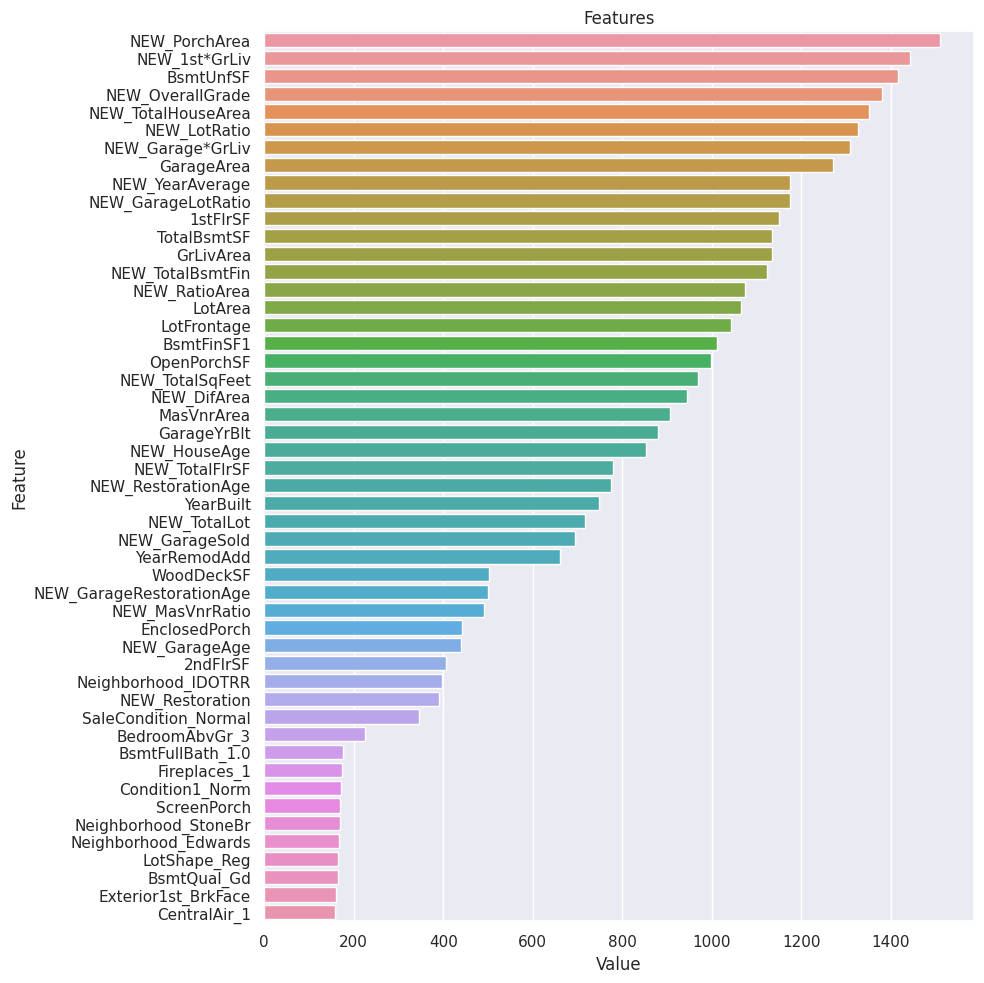

In [59]:
plot_importance(final_model, X)

In [60]:
model = LGBMRegressor()
model.fit(X, y)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7312
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 223
[LightGBM] [Info] Start training from score 12.024057


LGBMRegressor()

In [61]:
test_df.shape

(1459, 371)

In [62]:
test_df.head()

,Id,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,SalePrice,NEW_1st*GrLiv,NEW_Garage*GrLiv,NEW_TotalFlrSF,NEW_TotalBsmtFin,NEW_PorchArea,NEW_TotalHouseArea,NEW_TotalSqFeet,NEW_TotalLot,NEW_LotRatio,NEW_RatioArea,NEW_GarageLotRatio,NEW_MasVnrRatio,NEW_DifArea,NEW_OverallGrade,NEW_YearAverage,NEW_Restoration,NEW_HouseAge,NEW_RestorationAge,NEW_GarageAge,NEW_GarageRestorationAge,NEW_GarageSold,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_1,Alley_No,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_1,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_No,BsmtQual_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_1,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_No,GarageFinish_No,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_P,PavedDrive_Y,PoolQC_Fa,PoolQC_Gd,PoolQC_No,MiscFeature_No,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallQual_10,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,LowQualFinSF_53.0,LowQualFinSF_80.0,LowQualFinSF_108.0,LowQualFinSF_114.0,LowQualFinSF_120.0,LowQualFinSF_140.0,LowQualFinSF_144.0,LowQualFinSF_156.0,LowQualFinSF_205.0,Lo

In [63]:
test_df.tail()

,Id,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,SalePrice,NEW_1st*GrLiv,NEW_Garage*GrLiv,NEW_TotalFlrSF,NEW_TotalBsmtFin,NEW_PorchArea,NEW_TotalHouseArea,NEW_TotalSqFeet,NEW_TotalLot,NEW_LotRatio,NEW_RatioArea,NEW_GarageLotRatio,NEW_MasVnrRatio,NEW_DifArea,NEW_OverallGrade,NEW_YearAverage,NEW_Restoration,NEW_HouseAge,NEW_RestorationAge,NEW_GarageAge,NEW_GarageRestorationAge,NEW_GarageSold,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_1,Alley_No,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_1,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_No,BsmtQual_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_1,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_No,GarageFinish_No,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_P,PavedDrive_Y,PoolQC_Fa,PoolQC_Gd,PoolQC_No,MiscFeature_No,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallQual_10,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,LowQualFinSF_53.0,LowQualFinSF_80.0,LowQualFinSF_108.0,LowQualFinSF_114.0,LowQualFinSF_120.0,LowQualFinSF_140.0,LowQualFinSF_144.0,LowQualFinSF_156.0,LowQualFinSF_205.0,Lo

In [64]:
predictions = final_model.predict(test_df.drop(["Id","SalePrice"], axis=1))

In [65]:
dictionary = {"Id": [i + 1 for i in test_df.index], "SalePrice": predictions}

In [66]:
dfSubmission = pd.DataFrame(dictionary)

In [67]:
dfSubmission.head()

,Id,SalePrice
0,1461,11.797812
1,1462,12.021894
2,1463,12.125866
3,1464,12.154609
4,1465,12.150559


In [68]:
dfSubmission.tail()

,Id,SalePrice
1454,2915,11.317780
1455,2916,11.330193
1456,2917,11.904900
1457,2918,11.628245
1458,2919,12.363788


In [69]:
dfSubmission.to_csv("submission.csv", index=False)

In [70]:
submission = pd.read_csv("/kaggle/working/submission.csv")

In [71]:
submission.head()

,Id,SalePrice
0,1461,11.797812
1,1462,12.021894
2,1463,12.125866
3,1464,12.154609
4,1465,12.150559


In [72]:
submission.tail()

,Id,SalePrice
1454,2915,11.317780
1455,2916,11.330193
1456,2917,11.904900
1457,2918,11.628245
1458,2919,12.363788
